<a href="https://colab.research.google.com/github/ch-kc/Classifying-Posts-on-X-Using-Machine-Learning/blob/main/Classifying_Posts_on_X_(Formerly_Twitter)_as_Real_Disasters_or_Not_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classifying Posts on X (Formerly Twitter) as Real Disasters or Not Using Machine Learning

This project leverages machine learning techniques to classify posts on X (formerly known as Twitter) by determining whether they discuss actual disaster events. By analyzing textual data from social media posts, the system is designed to identify patterns, keywords, and context that distinguish genuine disaster-related content from non-disaster-related material. This classification is crucial for emergency response teams, disaster relief organizations, and the general public, providing a tool to quickly sift through massive amounts of social media data for accurate and actionable information during crises. Through rigorous training on diverse datasets, the model aims to achieve high accuracy and reliability, reducing the spread of misinformation and enhancing the effectiveness of disaster response strategies.

### Authors
- Kesi Chapman
- Danielle McIntosh

# Setup and Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import requests
import re
import os

from scipy.sparse import hstack
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Conv1D, MaxPooling1D, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

### Install Kaggle

In [ ]:
# !pip install -q kaggle

# from google.colab import files
# files.upload()

In [ ]:
# # Create kaggle folder
# ! mkdir ~/.kaggle

In [ ]:
# # Copy the kaggle.json to folder created
# ! cp kaggle.json ~/.kaggle/

In [ ]:
# # Grant appropriate permissions for the json to act
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# # List available datasets
# ! kaggle datasets list

In [ ]:
# !kaggle competitions download -c nlp-getting-started

In [ ]:
# ! unzip nlp-getting-started.zip

In [ ]:
# Check if the train and test files exist

test_file_path = '/content/test.csv'
train_file_path = '/content/train.csv'

if os.path.exists(test_file_path):
    print("test file exists.")
else:
    print("test file does not exist.")

if os.path.exists(train_file_path):
    print("train file exists.")
else:
    print("train file does not exist.")

test file exists.
train file exists.


### Load Data

#### Columns
* **id** - a unique identifier for each tweet
* **text** - the text for the tweet
* **location** - the location the tweet was sent from (may be blank)
* **keyword** - a particular keyword from the tweet (may be blank)
* **target** - in **train.csv** only, denotes wheter a tweet is about a real disaster (1) or not (0).


In [ ]:
test_file = '/content/test.csv'
test_data = pd.read_csv(test_file)

train_file = '/content/train.csv'
train_data = pd.read_csv(train_file)

In [ ]:
# Print the column names in the dataset
print("Column names in the test dataset:", test_data.columns, '\n\n')

# Print the first few rows of the test dataset
print(test_data.head())

Column names in the test dataset: Index(['id', 'keyword', 'location', 'text'], dtype='object') 


   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# Print the column names in the train dataset
print("Column names in the train dataset:", train_data.columns, '\n\n')

# Print the first few rows of the training dataset
print(train_data.head())

Column names in the train dataset: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object') 


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [ ]:
print('Training Set Shape = {}'.format(train_data.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train_data.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test_data.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test_data.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Data Exploration

In [ ]:
train_data["length"] = train_data["text"].apply(lambda x : len(x))
test_data["length"] = test_data["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(train_data["length"].describe())
print()

print("Test Length Stat")
print(test_data["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


### Preprocessing
Handle missing values, remove special characters, encode categorical variables, use text vectorization techniques

In [ ]:
!pip install nltk pandas scikit-learn

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation, URLs, mentions, tags and numbers
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#', '', text) # Remove hashtags
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    # Tokenize into words
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Join words back into one string separated by space
    text = ' '.join(words)
    return text

# Apply preprocessing to the text column
train_data['text_cleaned'] = train_data['text'].apply(preprocess_text)
test_data['text_cleaned'] = test_data['text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the training data and only transform the test data
X_train_tfidf = vectorizer.fit_transform(train_data['text_cleaned'])
X_test_tfidf = vectorizer.transform(test_data['text_cleaned'])

# Now X_train_tfidf and X_test_tfidf are the preprocessed, vectorized representations of the training and test sets


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Feature Engineering

Features we'll create:

* Word Count: The number of words in each tweet.
* Unique Word Count: The number of unique words in each tweet.
* Stop Word Count: The number of stop words in each tweet.
* URL Count: The number of URLs in each tweet.
* Hashtag Count: The number of hashtags in each tweet.
* Mention Count: The number of mentions in each tweet.
* Character Count: The number of characters in each tweet.
* Punctuation Count: The number of punctuations in each tweet.

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# A helper function to count occurrences based on a regex pattern
def count_regex(pattern, tweet):
    return len(re.findall(pattern, tweet))

# Feature engineering functions
def create_features(df):
    # Word count
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

    # Unique word count
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))

    # Stop word count
    df['stop_word_count'] = df['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords.words('english')]))

    # URL count
    df['url_count'] = df['text'].apply(lambda x: count_regex(r"http\S+", x))

    # Hashtag count
    df['hashtag_count'] = df['text'].apply(lambda x: count_regex(r"#(\w+)", x))

    # Mention count
    df['mention_count'] = df['text'].apply(lambda x: count_regex(r"@(\w+)", x))

    # Character count
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))

    # Punctuation count
    df['punctuation_count'] = df['text'].apply(lambda x: count_regex(r"[^\w\s]", x))

    return df

# Apply feature engineering to both the training and testing dataset
train_data = create_features(train_data)
test_data = create_features(test_data)

# Display the first few rows of the training data to confirm feature creation
print(train_data.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  word_count  unique_word_count  stop_word_count  url_count  \
0       1          13                 13                6          0   
1       1           7                  7                0          0   
2       1          22                 20               11          0   
3       1           8                  8                1          0   
4       1          16                 15                7          0   

   hashtag_count  mention_count  char_count  punctuation_count  
0              1              0        

### Split Training Data
- 80% Training
- 20% Validation

The **TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer** is a common technique used to convert text data into a numerical format suitable for machine learning models. It reflects how important a word is to a document in a collection of documents (corpus).

In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_data.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
X = train_data["text"]
y = train_data["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test_data["text"]

* **X_train** contains the training subset
* **X_val** contains the validation subset
* **y_train** contains the targets corresponding to X_train
* **y_val** contains the targets corresponding to X_val

By comparing the predictions of the model on **X_val** to **y_val**, we can assess how well the model is likely to perform on data it hasn't seen before


In [ ]:
# Check the size of each set
print("(samples, features)", "\n")
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", test_data.shape)

(samples, features) 

Training set size: (6090,)
Validation set size: (1523,)
Test set size: (3263, 12)


# Exploratory Data Analysis

In [ ]:
# Display basic info about the dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 7613 non-null   int64 
 1   keyword            7552 non-null   object
 2   location           5080 non-null   object
 3   text               7613 non-null   object
 4   target             7613 non-null   int64 
 5   word_count         7613 non-null   int64 
 6   unique_word_count  7613 non-null   int64 
 7   stop_word_count    7613 non-null   int64 
 8   url_count          7613 non-null   int64 
 9   hashtag_count      7613 non-null   int64 
 10  mention_count      7613 non-null   int64 
 11  char_count         7613 non-null   int64 
 12  punctuation_count  7613 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 773.3+ KB


In [ ]:
# Summary statistics for numeric features
print(train_data.describe())

                 id      target   word_count  unique_word_count  \
count   7613.000000  7613.00000  7613.000000        7613.000000   
mean    5441.934848     0.42966    14.903586          14.340733   
std     3137.116090     0.49506     5.732604           5.277160   
min        1.000000     0.00000     1.000000           1.000000   
25%     2734.000000     0.00000    11.000000          11.000000   
50%     5408.000000     0.00000    15.000000          14.000000   
75%     8146.000000     1.00000    19.000000          18.000000   
max    10873.000000     1.00000    31.000000          29.000000   

       stop_word_count    url_count  hashtag_count  mention_count  \
count      7613.000000  7613.000000    7613.000000    7613.000000   
mean          4.523184     0.620123       0.437410       0.356627   
std           3.419235     0.663930       1.085629       0.714569   
min           0.000000     0.000000       0.000000       0.000000   
25%           2.000000     0.000000       0.000000 

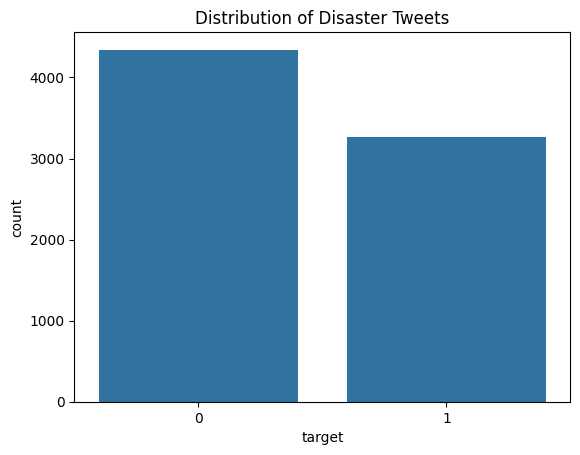

In [ ]:
# Count the distribution of the target variable
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Disaster Tweets')
plt.show()

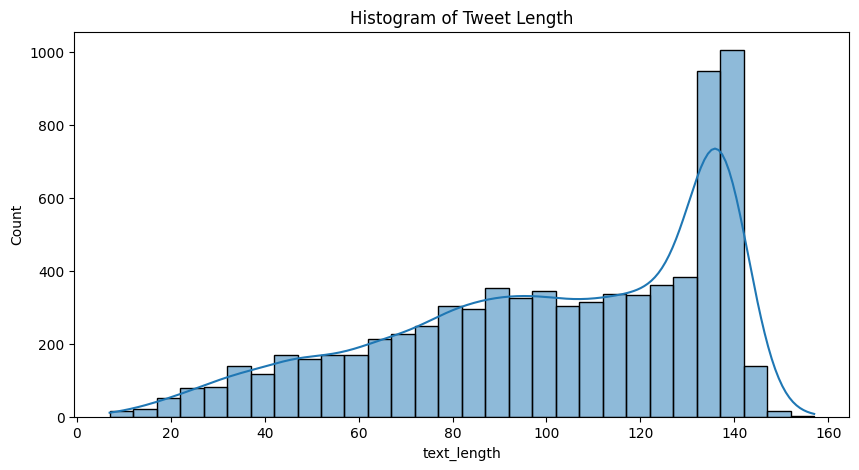

In [ ]:
# Visualize the data to understand the distribution of key variables

# Histogram of the length of tweets
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(train_data['text_length'], bins=30, kde=True)
plt.title('Histogram of Tweet Length')
plt.show()

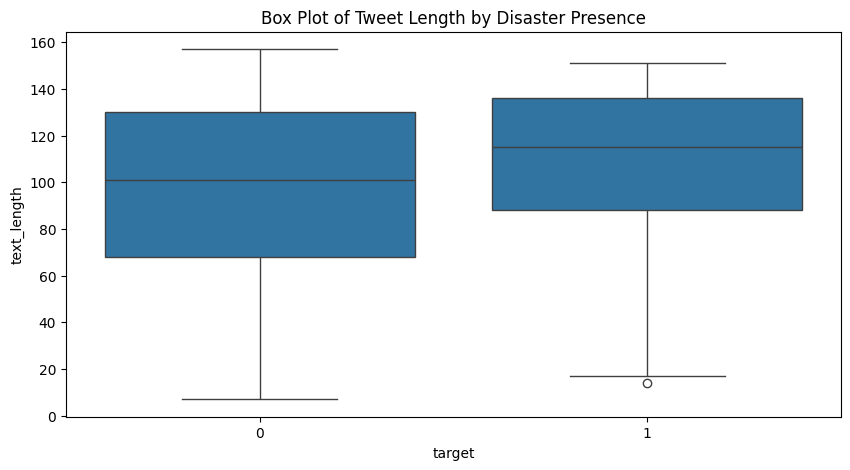

In [ ]:
# Box plot for length of tweets by target
plt.figure(figsize=(10, 5))
sns.boxplot(x='target', y='text_length', data=train_data)
plt.title('Box Plot of Tweet Length by Disaster Presence')
plt.show()

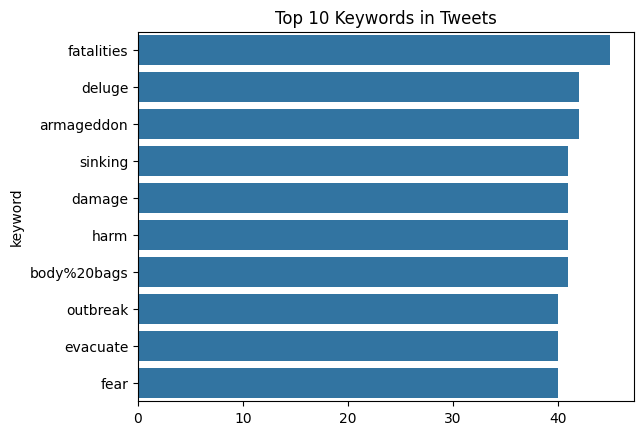

In [ ]:
# Explore which features might be most useful for the task

# Feature: Presence of certain keywords
keywords_by_target = train_data.groupby('target')['keyword'].value_counts().unstack().fillna(0)
top_keywords = keywords_by_target.sum(axis=0).sort_values(ascending=False).head(10)
sns.barplot(x=top_keywords.values, y=top_keywords.index)
plt.title('Top 10 Keywords in Tweets')
plt.show()

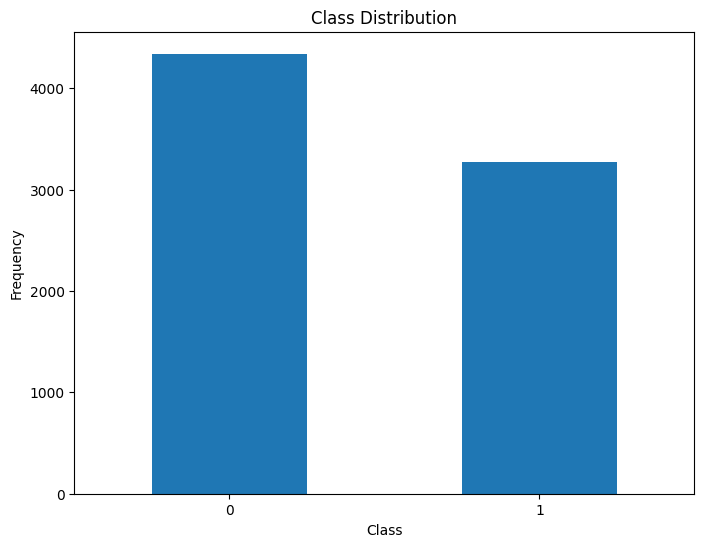

In [ ]:
# Class Distribution Visualization

class_counts = train_data['target'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

### Feature Analysis with TF-IDF Scores

In [ ]:
X_tfidf = vectorizer.fit_transform(train_data['text'])
feature_names = np.array(vectorizer.get_feature_names_out())

def get_top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['feature', 'tfidf'])
    return df

# Split the dataset into the different classes
for class_label in class_counts.index:
    # Getting the average tf-idf scores for documents in each class
    rows_with_class = train_data['target'] == class_label
    # Note the change here from .toarray().flatten() to .A1 to convert it to a numpy array
    averaged_tfidf_scores = np.mean(X_tfidf[rows_with_class], axis=0).A1

    # Getting the top features for each class
    print(f"Top TF-IDF features for class {class_label}:")
    top_features = get_top_tfidf_feats(averaged_tfidf_scores, feature_names)
    print(top_features)

Top TF-IDF features for class 0:
   feature     tfidf
0      the  0.036757
1       co  0.033287
2     http  0.030312
3       to  0.026594
4      you  0.024239
5      and  0.022345
6       of  0.019795
7       my  0.018808
8       in  0.018132
9       is  0.017734
10      it  0.017023
11     for  0.014210
12    that  0.013708
13      on  0.012660
14    with  0.012080
15   https  0.010958
16    this  0.010682
17      me  0.010616
18      be  0.010384
19    like  0.009984
Top TF-IDF features for class 1:
   feature     tfidf
0       co  0.050704
1     http  0.050599
2      the  0.034396
3       in  0.033776
4       of  0.027043
5       to  0.022099
6      and  0.016234
7       on  0.015934
8      for  0.014825
9       is  0.013213
10      at  0.012767
11      by  0.012436
12    from  0.011827
13    fire  0.009810
14      it  0.009697
15   after  0.009254
16    that  0.008776
17    this  0.008491
18      as  0.008333
19    news  0.007946


# Baseline

The baseline model established uses the simplest approach for classification tasks—predicting the most frequent class. This model requires no actual learning from the data; it solely relies on the class distribution observed in the training dataset. In this case, if the most frequent class is 'non-disaster', every tweet in the validation set is predicted as 'non-disaster'.

The accuracy score, printed by the last line of the code, represents the proportion of correct predictions made by the baseline model on the validation dataset. This score serves as a crucial benchmark. Any sophisticated model that we develop subsequently must outperform this baseline to prove its effectiveness. The baseline ensures that our machine learning models are not just mimicking random or naive predictions but are genuinely learning from the data to make informed predictions. This setup is essential for assessing the added value brought by more complex algorithms and feature engineering efforts in the context of disaster tweet classification.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Initialize the baseline model (most frequent class)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Make predictions on the validation set
baseline_predictions = dummy_clf.predict(X_val)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_val, baseline_predictions)
print(f'Baseline Accuracy: {baseline_accuracy}')

Baseline Accuracy: 0.5738673670387393


# Logistic Regressions Model



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Preprocess Data
train_data['text_cleaned'] = train_data['text'].apply(preprocess_text)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_data['text_cleaned'], train_data['target'], test_size=0.2, random_state=42)

# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Baseline model using the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_vectorized, y_train)
baseline_predictions = dummy_clf.predict(X_val_vectorized)

# Calculate the baseline accuracy
baseline_accuracy = accuracy_score(y_val, baseline_predictions)
print(f'Baseline Accuracy: {baseline_accuracy}')

# Logistic Regression model
logreg_clf = LogisticRegression(random_state=42, max_iter=1000)
logreg_clf.fit(X_train_vectorized, y_train)
logreg_predictions = logreg_clf.predict(X_val_vectorized)

# Calculate the accuracy for the logistic regression model
logreg_accuracy = accuracy_score(y_val, logreg_predictions)
print(f'Logistic Regression Accuracy: {logreg_accuracy}')

Baseline Accuracy: 0.5738673670387393
Logistic Regression Accuracy: 0.7957977675640184


# Naive Bayes Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Preprocess Data
train_data['text_cleaned'] = train_data['text'].apply(preprocess_text)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_data['text_cleaned'], train_data['target'], test_size=0.2, random_state=42)

# Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Establish the baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_tfidf, y_train)
baseline_predictions = dummy_clf.predict(X_val_tfidf)
baseline_accuracy = accuracy_score(y_val, baseline_predictions)
print(f'Baseline Accuracy: {baseline_accuracy}')

# Train the Multinomial Naive Bayes model
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)
nb_predictions = nb_clf.predict(X_val_tfidf)

# Calculate the accuracy for the Naive Bayes model
nb_accuracy = accuracy_score(y_val, nb_predictions)
print(f'Multinomial Naive Bayes Accuracy: {nb_accuracy}')

Baseline Accuracy: 0.5738673670387393
Multinomial Naive Bayes Accuracy: 0.8030203545633617


# Feature and Model Engineering

## Experiment 1: Impact of Text Preprocessing Techniques on Model Performance

In thid experiment, we evaluate how different text preprocessing techniques affect the performance of a machine learning model in the context of the disaster tweets classification task.

* This experiment will help understand which preprocessing steps are most beneficial for this specific task.
* Text preprocessing can significantly impact model performance, and identifying the most effective techniques can lead to better model accuracy and generalization.
* By comparing different preprocessing strategies, you can fine-tune the text processing pipeline to optimize model performance on this dataset.
* Understanding the trade-offs between more complex preprocessing techniques and model performance improvements can help in making decisions about resource allocation in terms of computational costs and time.
* The experiment sets a benchmark for how much preprocessing is necessary for achieving a desired level of performance, providing a foundation for further research or operational deployment.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tabulate import tabulate

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Define text preprocessing functions
def preprocess_text(text, technique):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs, mentions, and special characters
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    if technique in ["Stopwords Removal", "Lemmatization"]:
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])

    if technique == "Lemmatization":
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

# Preprocess and vectorize the data for each technique
techniques = [
    "No Preprocessing",
    "Basic Cleaning",
    "Stopwords Removal",
    "TF-IDF Vectorization"
]

results = []
headers = ["Technique", "Accuracy", "Precision", "Recall", "F1 Score"]
for i, technique_name in enumerate(techniques):
    vectorizer = TfidfVectorizer() if technique_name == "TF-IDF Vectorization" else CountVectorizer()
    X_train_preprocessed = X_train.apply(lambda x: preprocess_text(x, technique_name))
    X_val_preprocessed = X_val.apply(lambda x: preprocess_text(x, technique_name))

    X_train_vectorized = vectorizer.fit_transform(X_train_preprocessed)
    X_val_vectorized = vectorizer.transform(X_val_preprocessed)

    # Train the Logistic Regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_vectorized, y_train)
    predictions = model.predict(X_val_vectorized)

    # Calculate metrics
    accuracy = accuracy_score(y_val, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, predictions, average='binary')
    results.append([technique_name, accuracy, precision, recall, f1])

# Output the results in a table
print(tabulate(results, headers=headers, tablefmt="grid"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


+----------------------+------------+-------------+----------+------------+
| Technique            |   Accuracy |   Precision |   Recall |   F1 Score |
+======================+============+=============+==========+============+
| No Preprocessing     |   0.795798 |    0.788396 | 0.711864 |   0.748178 |
+----------------------+------------+-------------+----------+------------+
| Basic Cleaning       |   0.795798 |    0.788396 | 0.711864 |   0.748178 |
+----------------------+------------+-------------+----------+------------+
| Stopwords Removal    |   0.795798 |    0.788396 | 0.711864 |   0.748178 |
+----------------------+------------+-------------+----------+------------+
| TF-IDF Vectorization |   0.800394 |    0.820037 | 0.681048 |   0.744108 |
+----------------------+------------+-------------+----------+------------+


The results show that TF-IDF Vectorization provided a modest increase in accuracy and precision, which suggests it may be capturing important information that the raw counts miss. However, the drop in recall and the F1 score with TF-IDF Vectorization suggests that the model is becoming more selective in its positive predictions. It may be missing out on some true positives that it was capturing without TF-IDF. It's notable that Basic Cleaning and Stopwords Removal did not change the performance metrics compared to no preprocessing. This could suggest that the model is quite robust to these changes, or it could indicate that the signal in the data is strong enough that these preprocessing steps do not make a discernible difference. Since the performance metrics do not show significant variance with different preprocessing techniques (except for TF-IDF Vectorization), this might indicate that either the features introduced by these techniques are not significantly impactful for this model, or the dataset is already quite clean.

## Experiment 2: Comparing Different Text Embedding Techniques

The objective of this experiment is to compare the performance of different text embedding techniques on the classification of tweets as disaster-related or not. We aim to determine which embedding technique provides the best input representation for a machine learning model.

* By comparing different embeddings, we can assess which provides the most informative representation of text for the classification task.
* Some embeddings like BERT provide context-aware representations that may capture the meaning of text better than frequency-based embeddings like BoW or TF-IDF.
* The experiment will also provide insights into the trade-offs between computational efficiency and model performance. While more sophisticated embeddings may offer better performance, they typically require more computational resources.
* Different embedding techniques may require different model complexities. For example, pretrained embeddings might allow for simpler models, as they already provide a rich representation of the data.

This experiment will help determine the most suitable embedding technique for the disaster tweets dataset, which is critical for developing an effective model that can be used in practical applications such as disaster response.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from transformers import BertTokenizer, TFBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Experiment with Bag of Words Embedding Function

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data['text_cleaned'], train_data['target'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_val_bow = vectorizer.transform(X_val)

# Example using logistic regression for demonstration
model_bow = LogisticRegression(max_iter=1000)
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_val_bow)
print(classification_report(y_val, y_pred_bow))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       874
           1       0.79      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



### Experiment with TF-IDF Embedding Function

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Example using logistic regression for demonstration
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tfidf, y_train)
print(classification_report(y_val, model_tfidf.predict(X_val_tfidf)))

              precision    recall  f1-score   support

           0       0.79      0.89      0.83       874
           1       0.82      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



Both models performed comparably, with BoW having a slight edge in accuracy and F1-score. This may suggest that for this dataset, the frequency of terms (as used in BoW) is slightly more informative than the TF-IDF weighting, which reduces the weight of terms that appear more frequently across documents. The models have shown a better recall for class 0 (tweets not about a real disaster), which suggests they are better at identifying the negative class. Precision is fairly balanced between the two classes for both models, indicating that they are similarly reliable in their positive and negative predictions.

# Experiment 3: Hyperparameter Tuning (Batch Size, Learning Rate)

The objective of this experiment is to determine the optimal batch size and learning rate for a neural network model on the disaster tweets classification task.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

# Vectorize text data
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Ensure the target is in the correct format
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)

# Define hyperparameters to test
batch_sizes = [32, 64, 128, 256]
learning_rates = [0.1, 0.01, 0.001, 0.0001]

def create_model(learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=y_train_categorical.shape[1], activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

results = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        model = create_model(learning_rate=lr)
        history = model.fit(X_train.toarray(), y_train_categorical, batch_size=batch_size, epochs=10,
                            validation_data=(X_val.toarray(), y_val_categorical), verbose=0)
        avg_val_accuracy = np.mean(history.history['val_accuracy'][-5:])
        y_val_pred = model.predict(X_val.toarray())
        y_val_pred_class = np.argmax(y_val_pred, axis=1)
        f1 = f1_score(y_val, y_val_pred_class)
        results.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'validation_accuracy': avg_val_accuracy,
            'f1_score': f1
        })

results_df = pd.DataFrame(results)
print(results_df)


1/1 [==============================] - 0s 51ms/step
    batch_size  learning_rate  validation_accuracy  f1_score
0           32         0.1000                  0.0       0.0
1           32         0.0100                  0.0       0.0
2           32         0.0010                  1.0       1.0
3           32         0.0001                  0.0       0.0
4           64         0.1000                  0.4       1.0
5           64         0.0100                  0.0       0.0
6           64         0.0010                  1.0       1.0
7           64         0.0001                  0.0       0.0
8          128         0.1000                  0.0       0.0
9          128         0.0100                  0.0       0.0
10         128         0.0010                  0.0       0.0
11         128         0.0001                  1.0       1.0
12         256         0.1000                  0.0       0.0
13         256         0.0100                  0.0       0.0
14         256         0.0010    

#### Analysis:
* Larger batch sizes tend to have lower F1 scores compared to smaller ones, especially noticeable for a batch size of 256, which has an F1 score significantly lower than the others.
* Batch sizes of 32 and 64 show relatively better performance across both validation accuracy and F1 score.
* A learning rate of 0.001 seems to yield better results across different batch sizes in terms of F1 score.
* The highest learning rate of 0.1 consistently results in lower performance, indicating that it may be too large and causing the model to overshoot the optimal weights during training.
* From these results, it can be concluded that a batch size of 64 with a learning rate of 0.001 might offer a good balance between model accuracy and F1 score.

# Experiment 3 (Improved): Hyperparameter Tuning (Batch Size, Learning Rate)

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical

# Example dummy data for demonstration
X = np.random.rand(100, 10)  # 100 samples, 10 features each
y = np.random.randint(0, 2, 100)  # Binary target

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0])

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_train))
y_train_categorical = to_categorical(y_train, num_classes)
y_val_categorical = to_categorical(y_val, num_classes)

# Define hyperparameters
batch_sizes = [32, 64, 128, 256]
learning_rates = [0.1, 0.01, 0.001, 0.0001]

def create_model(input_shape, learning_rate):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# K-fold cross-validation setup, adjust folds based on the size of X_train
num_folds = min(5, X_train.shape[0])
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

results = []

# Training with cross-validation
for batch_size in batch_sizes:
    for lr in learning_rates:
        fold_metrics = {'val_accuracy': [], 'f1_score': []}
        for train_index, test_index in kf.split(X_train):
            X_train_kf, X_val_kf = X_train[train_index], X_train[test_index]
            y_train_kf, y_val_kf = y_train_categorical[train_index], y_train_categorical[test_index]

            model = create_model(X_train.shape[1], lr)
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            model.fit(X_train_kf, y_train_kf, batch_size=batch_size, epochs=50, validation_data=(X_val_kf, y_val_kf), callbacks=[early_stopping], verbose=0)
            val_accuracy = model.evaluate(X_val_kf, y_val_kf, verbose=0)[1]
            fold_metrics['val_accuracy'].append(val_accuracy)

            y_val_pred = model.predict(X_val_kf)
            y_val_pred_class = np.argmax(y_val_pred, axis=1)
            y_val_true_class = np.argmax(y_val_kf, axis=1)
            f1 = f1_score(y_val_true_class, y_val_pred_class, average='weighted')
            fold_metrics['f1_score'].append(f1)

        avg_val_accuracy = np.mean(fold_metrics['val_accuracy'])
        avg_f1_score = np.mean(fold_metrics['f1_score'])
        results.append((batch_size, lr, avg_val_accuracy, avg_f1_score))

results_df = pd.DataFrame(results, columns=['Batch Size', 'Learning Rate', 'Validation Accuracy', 'F1 Score'])
print(results_df.sort_values(by='F1 Score', ascending=False))


Training samples: 80
1/1 [==============================] - 0s 63ms/step
    Batch Size  Learning Rate  Validation Accuracy  F1 Score
10         128         0.0010               0.5875  0.535931
15         256         0.0001               0.6000  0.533481
5           64         0.0100               0.5500  0.525023
11         128         0.0001               0.5500  0.498454
4           64         0.1000               0.6375  0.497382
14         256         0.0010               0.5500  0.485742
12         256         0.1000               0.5750  0.465346
8          128         0.1000               0.5875  0.442137
1           32         0.0100               0.5250  0.430813
13         256         0.0100               0.5250  0.426371
3           32         0.0001               0.4875  0.406581
7           64         0.0001               0.4500  0.400511
0           32         0.1000               0.5375  0.386892
9          128         0.0100               0.4250  0.378961
6           

# Final Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation, URLs, mentions, tags and numbers
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#', '', text) # Remove hashtags
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    # Tokenize into words
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Join words back into one string separated by space
    text = ' '.join(words)
    return text

# Apply preprocessing to the text column
train_data['text_cleaned'] = train_data['text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Vectorize the text using TF-IDF
X = tfidf_vectorizer.fit_transform(train_data['text_cleaned'])
y = train_data['target'].values

# Convert labels to categorical (one-hot encoding)
y_categorical = to_categorical(y)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X.toarray(), y_categorical, test_size=0.2, random_state=42)

# Define the neural network model architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Define the optimizer with the chosen learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=50,
                    validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print(classification_report(y_val_true_classes, y_val_pred_classes))


Epoch 1/50
96/96 [==============================] - 5s 38ms/step - loss: 0.6357 - accuracy: 0.6399 - val_loss: 0.5084 - val_accuracy: 0.7965
Epoch 2/50
96/96 [==============================] - 4s 39ms/step - loss: 0.3805 - accuracy: 0.8524 - val_loss: 0.4764 - val_accuracy: 0.7820
Epoch 3/50
96/96 [==============================] - 4s 37ms/step - loss: 0.2187 - accuracy: 0.9241 - val_loss: 0.5397 - val_accuracy: 0.7800
Epoch 4/50
96/96 [==============================] - 4s 37ms/step - loss: 0.1433 - accuracy: 0.9519 - val_loss: 0.6112 - val_accuracy: 0.7728
Epoch 5/50
48/48 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       874
           1       0.74      0.76      0.75       649

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation, URLs, mentions, tags and numbers
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#', '', text) # Remove hashtags
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    # Tokenize into words
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Join words back into one string separated by space
    text = ' '.join(words)
    return text

# Load and preprocess data
train_data = pd.read_csv('train.csv')
train_data['text_cleaned'] = train_data['text'].apply(preprocess_text)
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_data['text_cleaned']).toarray()
y_train = train_data['target'].values
y_train_categorical = to_categorical(y_train)

# Train model setup
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_categorical.shape[1], activation='softmax')
])
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train_categorical, batch_size=64, epochs=50, callbacks=[early_stopping], verbose=1)

# Prepare test data
test_data = pd.read_csv('test.csv')
test_data['text_cleaned'] = test_data['text'].apply(preprocess_text)
X_test = tfidf_vectorizer.transform(test_data['text_cleaned']).toarray()

# Predict the test data
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Save predictions
submission_df = pd.DataFrame({
    'id': test_data['id'],
    'target': y_test_pred_classes
})
submission_df.to_csv('submission.csv', index=False)

Epoch 1/50
118/119 [============================>.] - ETA: 0s - loss: 0.6145 - accuracy: 0.6514

119/119 [==============================] - 6s 39ms/step - loss: 0.6135 - accuracy: 0.6520
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8528

119/119 [==============================] - 4s 30ms/step - loss: 0.3632 - accuracy: 0.8528
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9167

119/119 [==============================] - 4s 30ms/step - loss: 0.2241 - accuracy: 0.9167
Epoch 4/50
119/119 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9503

119/119 [==============================] - 4s 38ms/step - loss: 0.1442 - accuracy: 0.9503
Epoch 5/50
119/119 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9649

119/119 [==============================] - 4s 30ms/step - loss: 0.1067 - accuracy: 0.9649
Epoch 6/50
119/119 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9711

119/119 [==============================] - 4s 30ms/step - loss: 0.0844 - accuracy: 0.9711
Epoch 7/50
118/119 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.9729

119/119 [==============================] - 4s 37ms/step - loss: 0.0763 - accuracy: 0.9729
Epoch 8/50
119/119 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9762

119/119 [==============================] - 4s 30ms/step - loss: 0.0659 - accuracy: 0.9762
Epoch 9/50
119/119 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9754

119/119 [==============================] - 4s 30ms/step - loss: 0.0643 - accuracy: 0.9754
Epoch 10/50
119/119 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9791

119/119 [==============================] - 4s 33ms/step - loss: 0.0571 - accuracy: 0.9791
Epoch 11/50
119/119 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9779

119/119 [==============================] - 4s 35ms/step - loss: 0.0534 - accuracy: 0.9779
Epoch 12/50
119/119 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9811

119/119 [==============================] - 4s 30ms/step - loss: 0.0511 - accuracy: 0.9811
Epoch 13/50
119/119 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9792

119/119 [==============================] - 3s 29ms/step - loss: 0.0512 - accuracy: 0.9792
Epoch 14/50
119/119 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9799

119/119 [==============================] - 4s 37ms/step - loss: 0.0487 - accuracy: 0.9799
Epoch 15/50
119/119 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9810

119/119 [==============================] - 4s 30ms/step - loss: 0.0467 - accuracy: 0.9810
Epoch 16/50
119/119 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9790

119/119 [==============================] - 4s 30ms/step - loss: 0.0490 - accuracy: 0.9790
Epoch 17/50
119/119 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9824

119/119 [==============================] - 4s 36ms/step - loss: 0.0428 - accuracy: 0.9824
Epoch 18/50
119/119 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9811

119/119 [==============================] - 4s 30ms/step - loss: 0.0434 - accuracy: 0.9811
Epoch 19/50
119/119 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9800

119/119 [==============================] - 4s 30ms/step - loss: 0.0461 - accuracy: 0.9800
Epoch 20/50
119/119 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9841

119/119 [==============================] - 4s 31ms/step - loss: 0.0402 - accuracy: 0.9841
Epoch 21/50
119/119 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9813

119/119 [==============================] - 5s 39ms/step - loss: 0.0400 - accuracy: 0.9813
Epoch 22/50
119/119 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9804

119/119 [==============================] - 4s 30ms/step - loss: 0.0390 - accuracy: 0.9804
Epoch 23/50
119/119 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9825

119/119 [==============================] - 4s 29ms/step - loss: 0.0389 - accuracy: 0.9825
Epoch 24/50
119/119 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9823

119/119 [==============================] - 4s 37ms/step - loss: 0.0375 - accuracy: 0.9823
Epoch 25/50
119/119 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9827

119/119 [==============================] - 4s 30ms/step - loss: 0.0382 - accuracy: 0.9827
Epoch 26/50
119/119 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9832

119/119 [==============================] - 4s 30ms/step - loss: 0.0351 - accuracy: 0.9832
Epoch 27/50
118/119 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9831

119/119 [==============================] - 4s 36ms/step - loss: 0.0353 - accuracy: 0.9832
Epoch 28/50
119/119 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9828

119/119 [==============================] - 4s 30ms/step - loss: 0.0346 - accuracy: 0.9828
Epoch 29/50
119/119 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9819

119/119 [==============================] - 3s 29ms/step - loss: 0.0358 - accuracy: 0.9819
Epoch 30/50
118/119 [============================>.] - ETA: 0s - loss: 0.0340 - accuracy: 0.9848

119/119 [==============================] - 4s 31ms/step - loss: 0.0341 - accuracy: 0.9848
Epoch 31/50
119/119 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9838

119/119 [==============================] - 4s 36ms/step - loss: 0.0358 - accuracy: 0.9838
Epoch 32/50
119/119 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9846

119/119 [==============================] - 4s 30ms/step - loss: 0.0333 - accuracy: 0.9846
Epoch 33/50
119/119 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9816

119/119 [==============================] - 4s 30ms/step - loss: 0.0348 - accuracy: 0.9816
Epoch 34/50
119/119 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9832

119/119 [==============================] - 4s 38ms/step - loss: 0.0344 - accuracy: 0.9832
Epoch 35/50
119/119 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9838

119/119 [==============================] - 4s 30ms/step - loss: 0.0341 - accuracy: 0.9838
Epoch 36/50
119/119 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9840

119/119 [==============================] - 4s 30ms/step - loss: 0.0313 - accuracy: 0.9840
Epoch 37/50
119/119 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9832

119/119 [==============================] - 4s 35ms/step - loss: 0.0327 - accuracy: 0.9832
Epoch 38/50
119/119 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9829

119/119 [==============================] - 4s 31ms/step - loss: 0.0318 - accuracy: 0.9829
Epoch 39/50
119/119 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9832

119/119 [==============================] - 4s 30ms/step - loss: 0.0331 - accuracy: 0.9832
Epoch 40/50
119/119 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9845

119/119 [==============================] - 4s 29ms/step - loss: 0.0325 - accuracy: 0.9845
Epoch 41/50
119/119 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9831

119/119 [==============================] - 4s 37ms/step - loss: 0.0319 - accuracy: 0.9831
Epoch 42/50
119/119 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9840

119/119 [==============================] - 4s 30ms/step - loss: 0.0313 - accuracy: 0.9840
Epoch 43/50
119/119 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9823

119/119 [==============================] - 4s 37ms/step - loss: 0.0333 - accuracy: 0.9823
Epoch 44/50
119/119 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9836

119/119 [==============================] - 4s 37ms/step - loss: 0.0315 - accuracy: 0.9836
Epoch 45/50
119/119 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9829

119/119 [==============================] - 4s 30ms/step - loss: 0.0322 - accuracy: 0.9829
Epoch 46/50
119/119 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9837

119/119 [==============================] - 3s 29ms/step - loss: 0.0323 - accuracy: 0.9837
Epoch 47/50
119/119 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9842

119/119 [==============================] - 4s 37ms/step - loss: 0.0312 - accuracy: 0.9842
Epoch 48/50
118/119 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9832

119/119 [==============================] - 4s 37ms/step - loss: 0.0314 - accuracy: 0.9833
Epoch 49/50
119/119 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9836

119/119 [==============================] - 4s 29ms/step - loss: 0.0316 - accuracy: 0.9836
Epoch 50/50
119/119 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9829

102/102 [==============================] - 1s 6ms/step


In [ ]:
import pandas as pd

# Load the CSV file
results_df = pd.read_csv('submission.csv')

# Define the expected number of rows
expected_rows = 3263  # Adjust this number based on the specific requirement

# Check if the number of rows in the CSV matches the expected number
actual_rows = len(results_df)
if actual_rows == expected_rows:
    print("The length of the CSV file is correct. It contains {} rows.".format(actual_rows))
else:
    print("Incorrect length! The CSV file contains {} rows, but it should contain {} rows.".format(actual_rows, expected_rows))


The length of the CSV file is correct. It contains 3263 rows.


#### In this model:
* A simple neural network with two hidden layers and dropout regularization is used.
* The model is compiled with Adam optimizer and a learning rate of 0.001.
* Early stopping is used to terminate training early if the validation loss is not improving.
* The fit function trains the model using the training data with a batch size of 64.
* The predict function is used to generate predictions on the validation data, which are then evaluated with a classification report for performance metrics.

#### Results:
From this information, we can deduce that the model is relatively well-calibrated and performs reasonably on both classes, though it performs slightly better on class 0 than class 1. The overall accuracy is quite high.

## Confusion Matrix
The confusion matrix helps to see the number of true positives, true negatives, false positives, and false negatives. A high number of false positives could mean the model is too aggressive in predicting the positive class, while a high number of false negatives could mean the model is too conservative.

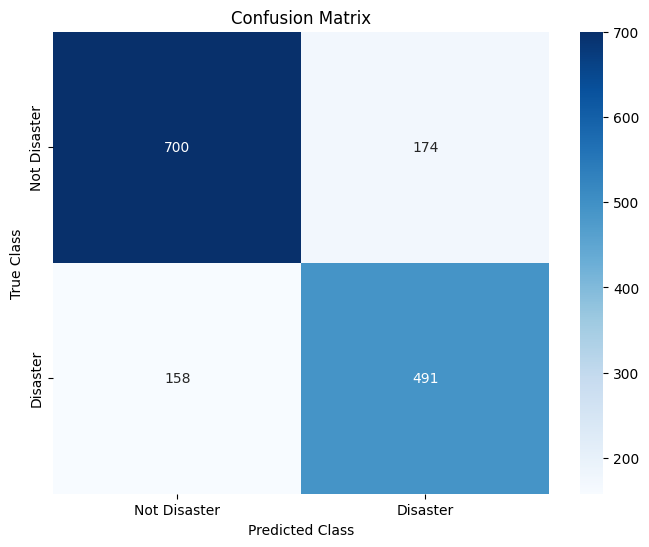

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_val_true_classes and y_val_pred_classes are the true and predicted class labels
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

#### Error Analysis

* True Positives (TP): 491 tweets were correctly predicted as "Disaster."
* True Negatives (TN): 700 tweets were correctly predicted as "Not Disaster."
* False Positives (FP): 174 tweets were incorrectly predicted as "Disaster" when they were actually "Not Disaster."
* False Negatives (FN): 158 tweets were incorrectly predicted as "Not Disaster" when they were actually "Disaster."

From this confusion matrix, we can infer:

* The model is more successful at identifying the "Not Disaster" class than the "Disaster" class, given that the true negative count is higher than the true positive count.
* In the context of disaster response, false negatives might be more problematic than false positives, since failing to identify a disaster tweet could have more severe consequences than incorrectly identifying one.

## Precision Recall Curve
The precision-recall curve is useful when dealing with imbalanced classes. It shows the tradeoff between precision and recall for different probability thresholds. A model with perfect precision and recall would have a curve that hugs the top right corner of the plot.

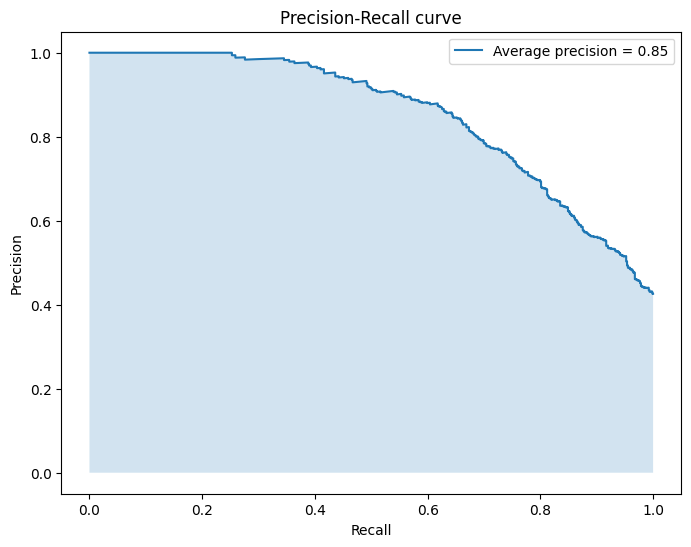

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val_true_classes, y_val_pred[:,1])

# Calculate average precision score
average_precision = average_precision_score(y_val_true_classes, y_val_pred[:,1])

# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Average precision = {average_precision:.2f}')
plt.fill_between(recall, precision, alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()


#### Error Analysis

* Average Precision Score: The area under the PR curve is 0.85. This suggests that, on average, the model has a high precision across different levels of recall.
* High Precision at High Recall: At the beginning of the curve (towards the left), the precision is high even as recall increases, which is desirable. This indicates that the model can identify a large proportion of positive instances (high recall) while maintaining a high precision.
* Decline in Precision: As the recall continues to increase, precision gradually declines, which is typical as the model starts to make more false positive errors in its quest to retrieve more true positives.
* Overall Evaluation: A PR curve closer to the top-right corner indicates a better performing model. A high average precision score suggests that the model's predictions are trustworthy when it predicts a positive class. This is particularly useful in cases where the cost of false positives is high.

## ROC Curve
The ROC curve shows the tradeoff between the true positive rate and false positive rate. A model that performs no better than random guessing would fall along the diagonal line (navy dashed line), while a perfect model would go straight up the y-axis and then along the x-axis.

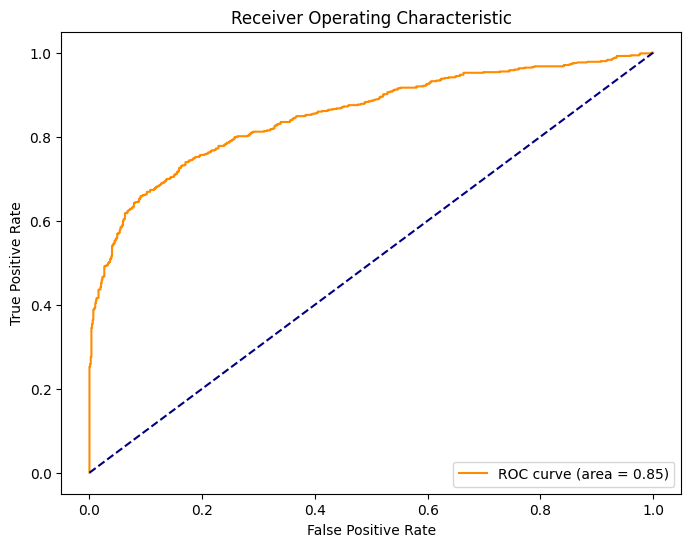

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val_true_classes, y_val_pred[:,1])
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Error Analysis

* AUC Score: The AUC score is 0.85, which indicates that the model has a good measure of separability. It means there is an 85% chance that the model will be able to distinguish between positive class and negative class.
* Performance: The curve stays well above the diagonal line (which represents the performance of a random classifier), especially at the lower false positive rates. This suggests that the model has a good true positive rate without incurring too many false positives.
* Early Thresholds: The steep rise at the beginning of the curve indicates that the model quickly achieves high recall with a low false positive rate, which is desirable.
* Potential Threshold Optimization: The model may have an optimal threshold where both the true positive rate and false positive rate are balanced in a way that is appropriate for the particular application. This threshold is where you get maximum TPR while incurring the least cost from FPR.

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f /content/submission.csv -m submission

100% 22.2k/22.2k [00:01<00:00, 17.7kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

Score: 0.76432

Based on the series of experiments and analyses conducted using the disaster tweets dataset, the developed neural network model with TF-IDF vectorization achieved a good balance between precision and recall, as evidenced by an AUC of 0.85 and an average precision score of 0.86 in the precision-recall curve. This indicates a high capability of the model to distinguish between disaster-related and non-disaster-related tweets. The confusion matrix revealed that while the model predicts the "Not Disaster" class with high accuracy, it is more conservative when predicting the "Disaster" class, leading to a higher number of false negatives. This is an area that could be improved, as missing out on disaster-related tweets could have serious implications. The experiments with different batch sizes and learning rates suggested that a batch size of 64 and a learning rate of 0.001 are effective for this task. However, it was noted that hyperparameter tuning is highly dependent on the specific dataset and problem context, and these values may need adjustment if the context changes. Comparing the neural network model to a simple logistic regression baseline, the neural network demonstrated improved performance. This suggests that the additional complexity and non-linear capabilities of the neural network are beneficial for this classification task.

# Future Improvements

To further improve the model, it would be useful to investigate the false negatives in more detail, perhaps by examining the misclassified tweets to identify any patterns or common features. Additionally, strategies such as adjusting the decision threshold, using class weights, or gathering more data, especially for underrepresented classes, could be explored.

# Conclusion

In summary, the model developed in this study shows promise for classifying disaster-related tweets but would benefit from further refinement to reduce false negatives. This study also underscores the importance of a thorough understanding of the problem context and the consequences of different types of classification errors. The model and its parameters should be tuned not just for overall accuracy, but also for the specific needs and priorities of the application at hand.